# State of Art Model (XGboost)
---
Using gradient boosting model

In [45]:
# Basic 
import sys
import json

# Warning problems in notebook
import warnings
warnings.filterwarnings('ignore')

# Profiling process
from tqdm import tqdm

# Reporting result
from IPython.display import display

# Math
import numpy as np
import scipy as sp
import pandas as pd

# Statistics
from statsmodels.stats.outliers_influence import variance_inflation_factor

# SQL Engine
import psycopg2
import pandas as pd
from sqlalchemy import create_engine

# Visualization
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

# Reporting result
import sweetviz as sv
from dataprep.eda import create_report, plot, plot_missing, plot_correlation

# Metrics
from sklearn import metrics

# Learning Helper | Modelling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LinearRegression, PoissonRegressor, RANSACRegressor

import xgboost
import joblib

from lightgbm import LGBMRegressor
import lightgbm as lgbm

# CLustering
from sklearn.cluster import KMeans

# Dimension reductionality
from sklearn.decomposition import PCA

In [5]:
# Progress apply for pandas
tqdm.pandas()

# Seaborn color palette
sns.set_palette('husl')

# Inline matplotlib
%matplotlib inline

# Plotting pretty figures and avoid blurry images
%config InlineBackend.figure_format = 'retina'

# Larger scale for plots in notebooks
sns.set_context('notebook')

# Showing all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [6]:
# Calculating multicollinearity
def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

# Saving model 
def save_model(model, name="model"):
    pickle.dump(model, open(f"../bin/{name}", "wb"))
    
# Scaling
def scale(data,cols,transformer = StandardScaler()):
    new_data = data.copy()
    pbar_scale = tqdm(cols)
    for i in pbar_scale:
        pbar_scale.set_description(f"Processing : {i}")
        new_data[i] = transformer.fit_transform(new_data[i].values.reshape(-1,1))
    return new_data 

# Encode
def one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode 
    @return a DataFrame with one-hot encoding
    """
    new_cols = []
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
        for col in dummies.columns:
            new_cols.append(col)
    return df, new_cols

In [18]:
# === Load data ===

## EDIT THIS CODE
# =====================
filename = "../data/processed/dataset-supervised-processed.pkl"
# =====================

target = "wd_actual_delivery_interval"

df = pd.read_pickle(filename)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90183 entries, 0 to 95126
Data columns (total 35 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   total_unique_item                90183 non-null  int64  
 1   product_volume_cm3_per_item      90183 non-null  float64
 2   product_weight_g_per_item        90183 non-null  float64
 3   order_day_of_week                90183 non-null  int64  
 4   order_day_of_month               90183 non-null  int64  
 5   order_quarter                    90183 non-null  float64
 6   order_is_weekend                 90183 non-null  bool   
 7   order_hour                       90183 non-null  int64  
 8   order_daytime                    90183 non-null  object 
 9   order_approved_day_of_week       90183 non-null  float64
 10  order_approved_day_of_month      90183 non-null  float64
 11  order_approved_quarter           90183 non-null  float64
 12  order_approved_is_

<AxesSubplot:xlabel='wd_actual_delivery_interval'>

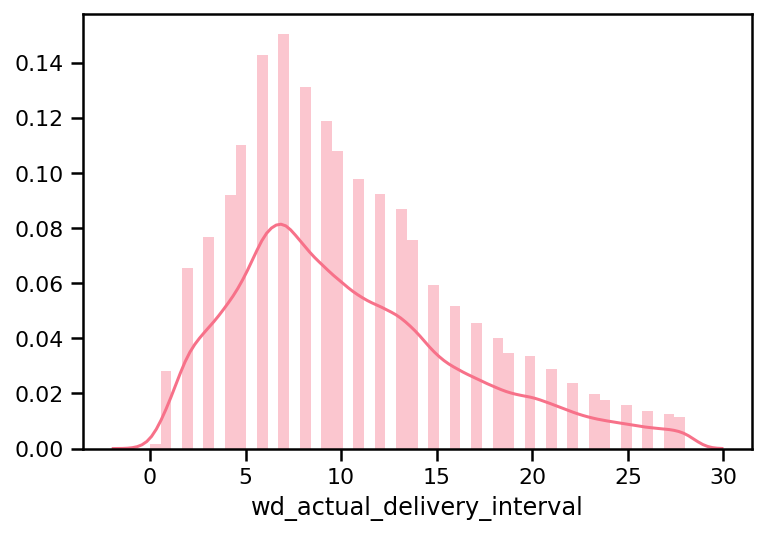

In [19]:
# === Show distribution of target value ===
sns.distplot(df[target])

In [25]:
cat_num_features =['order_quarter', 'order_is_weekend',
                               'order_approved_quarter', 'order_approved_is_weekend',
                               'pickup_limit_quarter', 'pickup_limit_is_weekend', "is_same_area"]
cat_str_features = ["order_daytime", "order_approved_daytime"]

for col in tqdm(cat_num_features):
    df[col] = df[col].astype(int)

for col in tqdm(cat_str_features):
    enc = LabelEncoder()
    df[col] = enc.fit_transform(df[col])

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 24.78it/s]


In [26]:
target = "wd_actual_delivery_interval"
X = df.drop([target] + ["wd_estimated_delivery_interval"], axis = 1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.2)

train = X_train.copy()
train[target] = y_train.values
val = X_test.copy()
val[target] = y_test.values

In [41]:
ignored_features = []

# === Load Model ===
# model = joblib.load('../bin/lgbm-regressor.model')

param = {
    'learning_rate' : 0.15,
    'random_state' : 123,
    'n_iteration' : 1000,
}

fit_param = {
    'eval_set' : (X_test, y_test),
    'categorical_feature' :  cat_num_features + cat_str_features,
    'verbose' : 10,
    'early_stopping_rounds': 500,
}
model = LGBMRegressor(**param)
model.fit(X_train, y_train, **fit_param)
joblib.dump(model, '../bin/lgbm-regressor.model')

[LightGBM] [Warning] Unknown parameter: n_iteration
Training until validation scores don't improve for 500 rounds
[10]	valid_0's l2: 25.8856
[20]	valid_0's l2: 24.4198
[30]	valid_0's l2: 23.7957
[40]	valid_0's l2: 23.3982
[50]	valid_0's l2: 23.1345
[60]	valid_0's l2: 22.9978
[70]	valid_0's l2: 22.8598
[80]	valid_0's l2: 22.7859
[90]	valid_0's l2: 22.7343
[100]	valid_0's l2: 22.6733
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 22.6733


LGBMRegressor(learning_rate=0.15, n_iteration=1000, random_state=123)

['../bin/lgbm-regressor.model']

In [42]:
def evaluate_model(true, predicted):  
    rmsle = metrics.mean_squared_log_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2 = metrics.r2_score(true, predicted)
    print('RMSLE:',rmsle)
    print('RMSE:', rmse)
    print("R2:", r2)
    print('__________________________________')
    return rmsle, rmse, r2 

pred = model.predict(X_test)
evaluate_model(y_test, pred)

RMSLE: 0.18876349336396928
RMSE: 4.761650008550699
R2: 0.3778110462511374
__________________________________


(0.18876349336396928, 4.761650008550699, 0.3778110462511374)

<Figure size 1440x720 with 0 Axes>

<AxesSubplot:xlabel='Value', ylabel='Feature'>

Text(0.5, 1.0, 'LightGBM Features (avg over folds)')

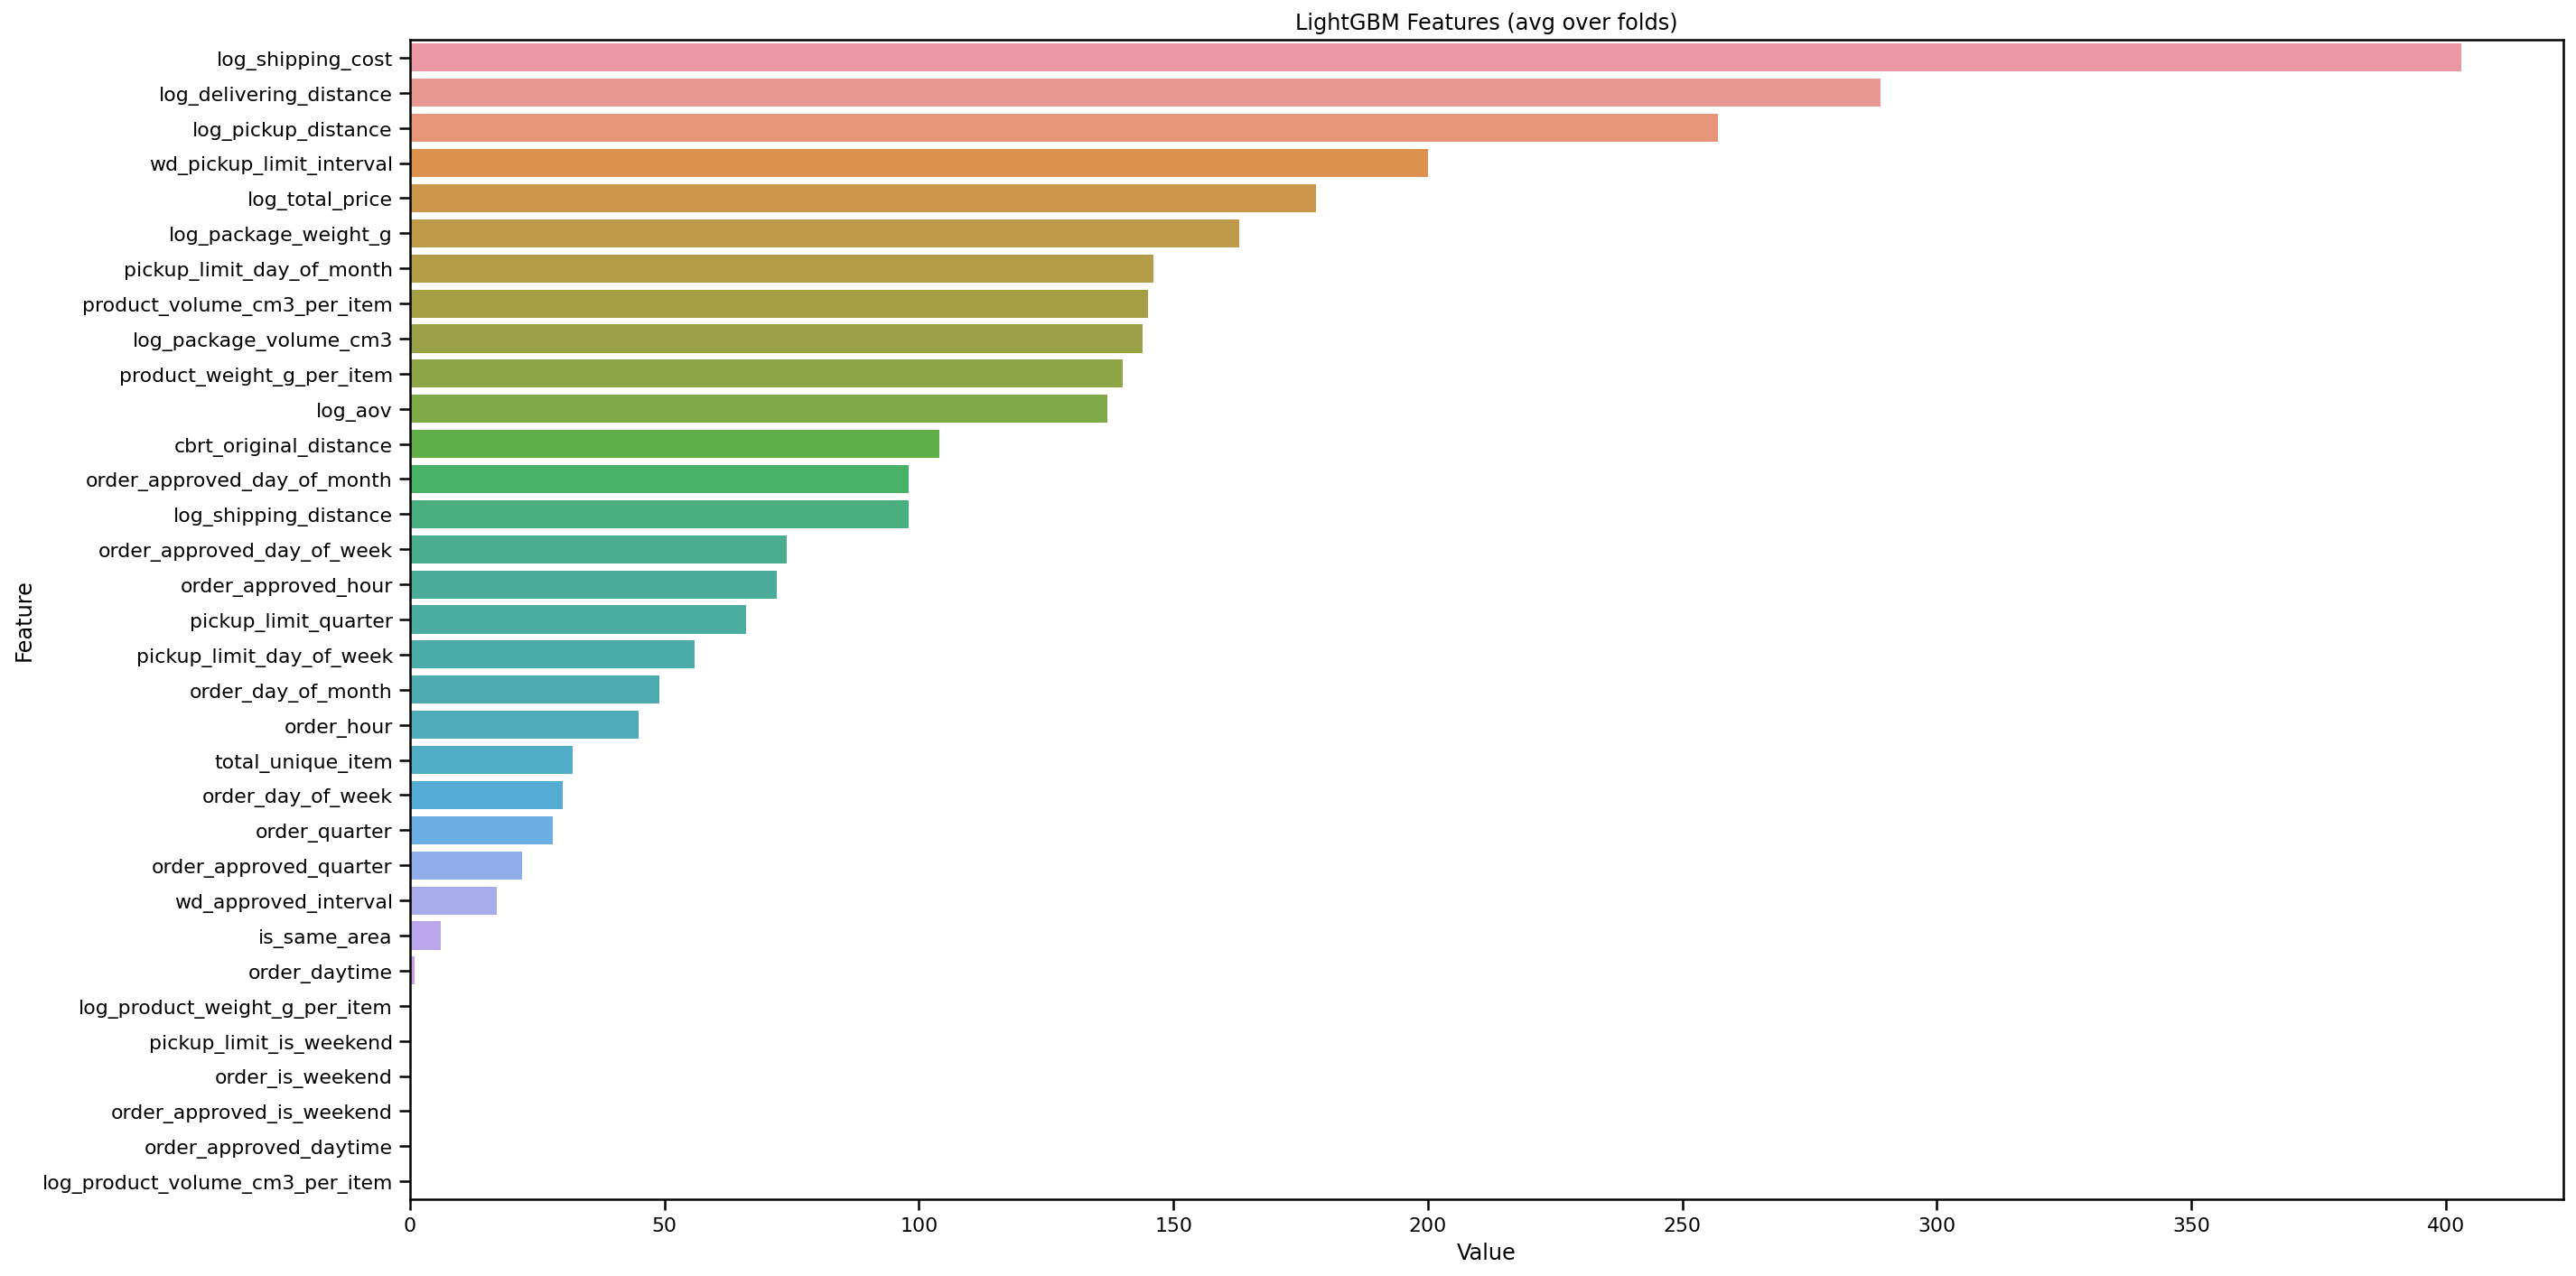

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='wd_actual_delivery_interval'>

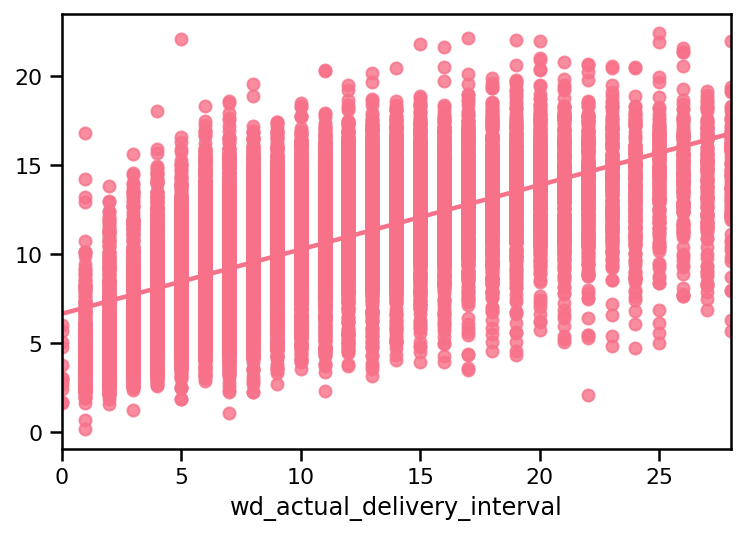

In [46]:
sns.regplot(y_test, pred)